In [1]:
import pandas as pd 
import numpy as np
from collections import  OrderedDict
from copy import deepcopy
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc
plt.rcParams.update({"text.usetex": True})
plt.rcParams['font.family']='sans-serif'

In [2]:
def gen_path(solver, regularizer, actual_seed, depth, remove_ratio, 
             purpose='leastsquare_btree/details', loss='ls', task='btree', lammax=1.0, lam_shrink=1e-2, **kwargs):
    task_hypers_template = {
                    'ProxGD':   OrderedDict({'proxgd_stepsize': 'linesearch'}),
                    'ProxSAGA': OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None, 'proxsaga_lipcoef': 1.0,}),
                    'ProxSVRG': OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None, 'proxsvrg_inner_repeat': 1, 'proxsvrg_lipcoef': 1.0}),
                    'PStorm':   OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None,'pstorm_stepsize': 'diminishing', 'pstorm_betak': -1.0, 'pstorm_lipcoef': 1.0}),
                    'RDA':      OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None, 'rda_stepconst': 10.0}),
                    'SPStorm':  OrderedDict({ 'ipg_strategy': 'diminishing', 'seed':None, 'spstorm_betak': -1.0, 'spstorm_zeta': 'dynanmic', 'spstorm_lipcoef': 1.0})
                }
    solver_hyper = task_hypers_template[solver]
    if solver != 'ProxGD':
        solver_hyper['seed'] = actual_seed
    for k in kwargs:
        if k in task_hypers_template:
            kwargs[k] = v
    dataset = f'ls_dep:{depth}_num:2x_sparse:0.1'
    path = f'../{purpose}/{solver}_{loss}_{regularizer}/{dataset}_lam_shrink:{lam_shrink}_{task}_{lammax}_{depth}_True_{remove_ratio}_{-1.0}'
    for k,v in solver_hyper.items():
        if k == 'ipg_strategy':
            path += f'_{v}'
        else:
            path += f'_{k}:{v}'
    path += '_stats.npy'
    return path

In [3]:
# solver = 'ProxGD'
# path = gen_path(solver, regularizer='TreeOG', actual_seed=2023, depth=11, remove_ratio=0.05)
# np.load(path,  allow_pickle=True).item().keys()
# solver = 'ProxSVRG'
# path = gen_path(solver, regularizer='NatOG', actual_seed=2023, depth=11, remove_ratio=0.05)
# np.load(path,  allow_pickle=True).item().keys()

In [4]:
def collect_one_run(actual_seed, depth, remove_ratio, solvers=["ProxSVRG", "ProxSAGA", "RDA", "PStorm", "SPStorm"]):
    filename = gen_path('ProxGD', regularizer='TreeOG', actual_seed=actual_seed, depth=depth, remove_ratio=remove_ratio)
    info_gt = np.load(filename,  allow_pickle=True).item()
    all_solver_stats = {}
    all_solver_stats['ProxGD'] = {'xsol' : info_gt['xend'], 'nz' : info_gt['nz'], 'F' : info_gt['Fend']}
    for solver in solvers:
        filename = gen_path(solver, regularizer='NatOG', actual_seed=actual_seed, depth=depth, remove_ratio=remove_ratio)
        info = np.load(filename,  allow_pickle=True).item()
        all_solver_stats[solver] = {}
        all_solver_stats[solver]['num_data_pass'] = info['num_data_pass']
        all_solver_stats[solver]['F_seq'] = np.array(info['F_seq'])
        all_solver_stats[solver]['nz_seq'] = np.array(info['nz_seq'])
        all_solver_stats[solver]['x_seq'] = np.array(info['x_seq'])        
        all_solver_stats[solver]['grad_error_seq'] = np.array(info['grad_error_seq'])
        all_solver_stats[solver]['time_seq'] = info['time_seq']
        all_solver_stats[solver]['total_bak_seq'] = info['total_bak_seq']
        all_solver_stats[solver]['inner_its_seq'] = info['inner_its_seq']        
        all_solver_stats[solver]['xend'] = info['xend']
        
        first_identification = 0
        for i in range(len(all_solver_stats[solver]['nz_seq'])-1, -1, -1):
            if np.array(info['nz_seq'][i]) != info_gt['nz']:
                # the previous one is the first id
                first_identification = i + 1
                break
        if solver == "ProxSVRG":
            first_identification = (first_identification + 1) // 2
            max_epoch = (len(np.array(info['nz_seq'])) - 1) // 2
        else:
            max_epoch = (len(np.array(info['nz_seq'])) - 1) 
            
        if first_identification == 0 or first_identification == (max_epoch + 1):
            first_identification = -1
        all_solver_stats[solver]['first_identification'] = first_identification
        all_solver_stats[solver]['total_identification'] = np.sum(all_solver_stats[solver]['nz_seq']==info_gt['nz'])
        all_solver_stats[solver]['is_consistent_identification'] = first_identification >= 1
    problem_id = f"{depth}_{remove_ratio}"
    return problem_id, all_solver_stats

def create_df(seed_lst, depth_lst, remove_ratio_lst, solvers=["ProxSVRG", "ProxSAGA", "RDA", "PStorm", "SPStorm"], max_epoch = 500):
    df_dict = {'problem_id':[], 'ProxGD_F':[], 'ProxGD_nz':[]}
    for solver in solvers:
        df_dict[f"{solver}_best_F"] = []
        df_dict[f"{solver}_best_F_std"] = []        
        df_dict[f"{solver}_last_nz"] = []
        df_dict[f"{solver}_last_nz_std"] = []        
        df_dict[f"{solver}_first_id"] = []
        df_dict[f"{solver}_first_id_std"] = []        
        df_dict[f"{solver}_first_cst_id"] = []
        df_dict[f"{solver}_first_cst_id_std"] = []
        df_dict[f"{solver}_total_id"] = []
        df_dict[f"{solver}_total_id_std"] = []        
    for depth in depth_lst:
        for remove_ratio in remove_ratio_lst:
            problem_id = f"{depth}_{remove_ratio}"
            df_dict['problem_id'].append(problem_id)
            filename = gen_path('ProxGD', regularizer='TreeOG', actual_seed=None, depth=depth, remove_ratio=remove_ratio)
            info_gt = np.load(filename,  allow_pickle=True).item()
            nz_gt = info_gt['nz']
            F_gt = info_gt['Fend']
            df_dict['ProxGD_F'].append(F_gt)
            df_dict['ProxGD_nz'].append(nz_gt)                
            for solver in solvers:
                best_F_lst = []
                last_nz_lst = []
                first_id_lst = []
                first_consistent_id_lst = []
                total_id_lst = []
                for actual_seed in seed_lst:
                    try:
                        filename = gen_path(solver, regularizer='NatOG', actual_seed=actual_seed, depth=depth, remove_ratio=remove_ratio)
                        info = np.load(filename,  allow_pickle=True).item()
                    except FileNotFoundError:
                        info = None
                    if info is not None:
                        F_seq = np.array(info['F_seq'])
                        nz_seq = np.array(info['nz_seq'])
                        if solver == "ProxSVRG":
                            F_seq = F_seq[:max_epoch+1]
                            nz_seq = nz_seq[:max_epoch+1]
                        temp = np.where(nz_seq == nz_gt)[0]
                        total_identification = len(temp)
                        if total_identification > 0:
                            first_identification = temp[0]
                            first_consistent_identification = np.nan
                            for i in range(len(nz_seq)-1, -1, -1):
                                if np.array(nz_seq[i]) != nz_gt:
                                    # the previous one is the first id
                                    first_consistent_identification = i + 1
                                    break
                            if first_consistent_identification == 0 or first_consistent_identification == (max_epoch+1):
                                first_consistent_identification = np.nan
                        else:
                            first_identification = first_consistent_identification = total_identification = np.nan
                    else:
                        # no result
                        F_seq = np.nan
                        nz_seq = [np.nan]
                        first_identification = first_consistent_identification = total_identification = np.nan

                    best_F_lst.append(np.min(F_seq))
                    last_nz_lst.append(nz_seq[-1])
                    first_id_lst.append(first_identification)
                    first_consistent_id_lst.append(first_consistent_identification)
                    total_id_lst.append(total_identification)
                # end of the for loop for seed_lst
                df_dict[f"{solver}_best_F"].append(np.mean(best_F_lst))
                df_dict[f"{solver}_best_F_std"].append(np.std(best_F_lst))
                df_dict[f"{solver}_last_nz"].append(np.mean(last_nz_lst))
                df_dict[f"{solver}_last_nz_std"].append(np.std(last_nz_lst))                    
                df_dict[f"{solver}_first_id"].append(np.mean(first_id_lst))
                df_dict[f"{solver}_first_id_std"].append(np.std(first_id_lst))
                df_dict[f"{solver}_first_cst_id"].append(np.mean(first_consistent_id_lst))
                df_dict[f"{solver}_first_cst_id_std"].append(np.std(first_consistent_id_lst))                        
                df_dict[f"{solver}_total_id"].append(np.mean(total_id_lst))
                df_dict[f"{solver}_total_id_std"].append(np.std(total_id_lst))
    return pd.DataFrame.from_dict(df_dict)    

In [5]:
# collect_one_run(actual_seed=2023, depth=11, remove_ratio=0.05)[1].keys()
df = create_df(seed_lst=[2023], depth_lst=[11,12,13,14,15], remove_ratio_lst=[0.05, 0.1, 0.20], max_epoch = 500)

In [6]:
solvers=["RDA", "PStorm", "SPStorm","ProxSVRG", "ProxSAGA"]
metric = 'total_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
print(f"All failed in {all_failed_count} / {df_.shape[0]} cases")
df_valid = df[~all_failed_index][['problem_id']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=True, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for solver in solvers:
    df_score[f'{solver}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
total_id_score = df_score.sum(axis=0).to_numpy()

metric = 'first_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['problem_id']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for solver in solvers:
    df_score[f'{solver}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
first_id_score = df_score.sum(axis=0).to_numpy()

metric = 'first_cst_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
df_valid = df[~all_failed_index][['problem_id']+cols]
# higher score; the better; break tie by max
df_score= df_valid.rank(axis=1, method='max', ascending=False, numeric_only=True)
df_score['correction'] = df_valid.isnull().sum(axis=1)
for solver in solvers:
    df_score[f'{solver}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
first_cst_id_score = df_score.sum(axis=0).to_numpy()

metric = 'last_nz'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols+['ProxGD_nz']]
df_percent_identified = df_.copy()
for solver in solvers:
    df_percent_identified[f'{solver}_{metric}'] = 1 - np.abs(df_percent_identified[f'{solver}_{metric}'] - df_percent_identified['ProxGD_nz']) / df_percent_identified['ProxGD_nz']
df_percent_identified = df_percent_identified[cols]
# higher score; the better; break tie by max
df_score= df_percent_identified.rank(axis=1, method='max', ascending=True, numeric_only=True)
df_score['correction'] = df_percent_identified.isnull().sum(axis=1)
for solver in solvers:
    df_score[f'{solver}_{metric}'] += df_score['correction']
df_score = df_score.fillna(0)[cols]
last_nz_score = df_score.sum(axis=0).to_numpy()

index = ['total identification', 'first identification', 'first consistent identification', 'last iterate support recovery']
plot_df_dict = {}
for i in range(len(solvers)):
    plot_df_dict[solvers[i]] = [total_id_score[i], first_id_score[i], first_cst_id_score[i], last_nz_score[i]]
plot_df = pd.DataFrame.from_dict(plot_df_dict)
plot_df.index = index
plot_df_row_sum = plot_df.sum(1)
for i in range(len(plot_df_row_sum)):
    for col in solvers:
        plot_df[col][i] /= plot_df_row_sum[i]

All failed in 0 / 15 cases


In [7]:
plot_df

,RDA,PStorm,SPStorm,ProxSVRG,ProxSAGA
total identification,0.000000,0.000000,0.385870,0.293478,0.320652
first identification,0.000000,0.000000,0.402174,0.244565,0.353261
first consistent identification,0.000000,0.000000,0.402174,0.244565,0.353261
last iterate support recovery,0.066421,0.103321,0.276753,0.276753,0.276753


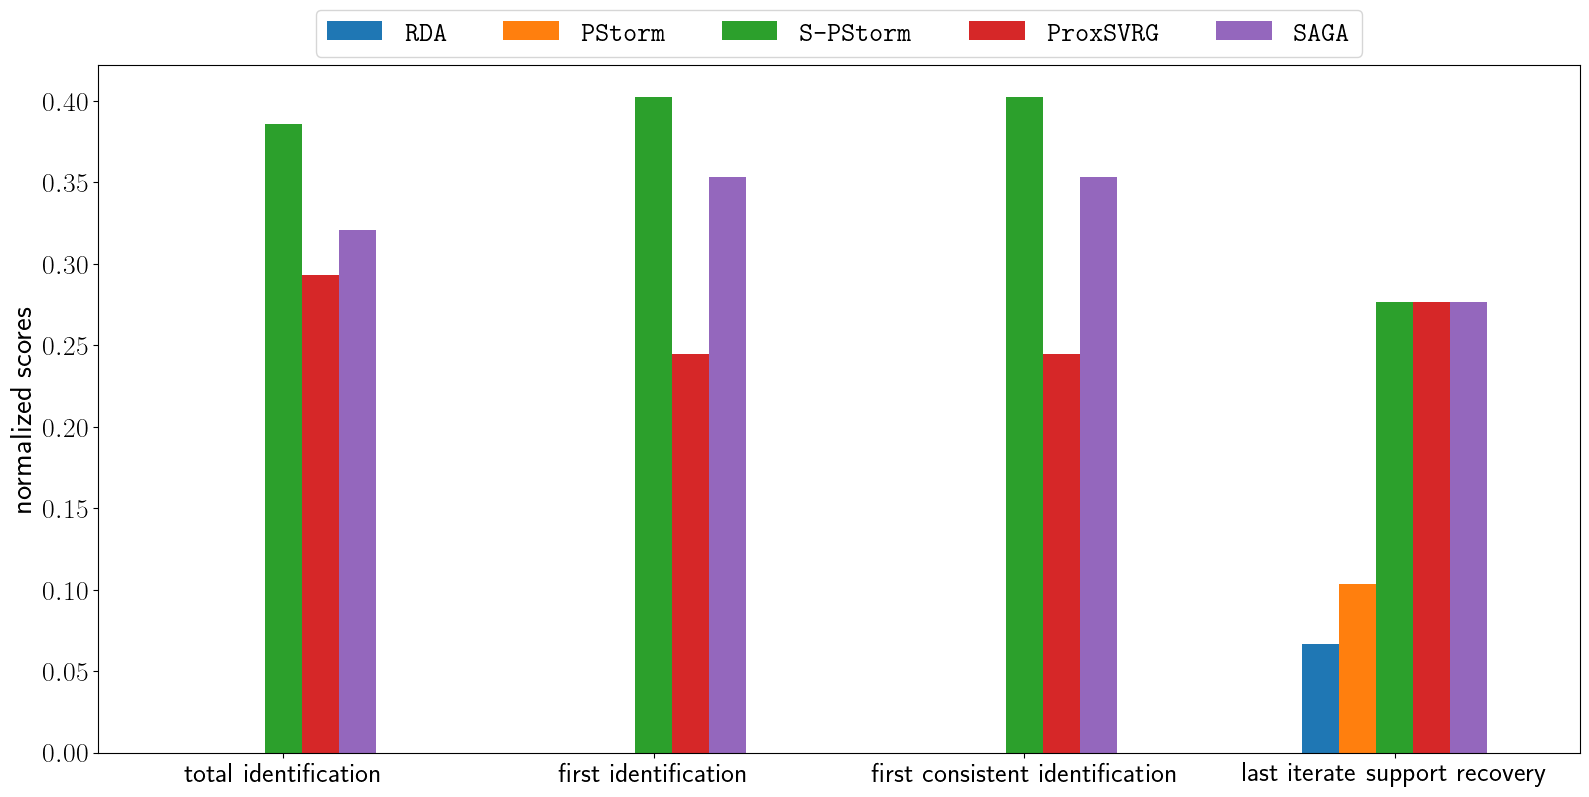

In [8]:
legend_label=[r'$\texttt{RDA}$', r'$\texttt{PStorm}$', r'$\texttt{S-PStorm}$', r'$\texttt{ProxSVRG}$', r'$\texttt{SAGA}$']
plot_df = plot_df[['RDA', 'PStorm',	'SPStorm', 'ProxSVRG', 'ProxSAGA']]
ax = plot_df.plot.bar(rot=0, figsize=(16, 8), fontsize=20)
L=ax.legend(legend_label, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(solvers), fancybox=True, prop={'size': 20, 'family':'monospace'})
plt.ylabel('normalized scores', fontdict={'size': 22})
plt.tight_layout(w_pad=0)
plt.savefig('./figs/supp_id_ipg_ls_tree.pdf', dpi=100)

In [9]:
def identity(x):
    return str(x)
def rm_underscore(x):
    return "-".join(x.split("_"))
# solvers=["ProxSVRG", "ProxSAGA", "RDA", "PStorm", "SPStorm"]

In [10]:
metric = 'total_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
all_failed_index = df_.isin([np.nan]).all(1)
all_failed_count = np.sum(all_failed_index)
print(f"All failed in {all_failed_count} / {df_.shape[0]} cases\n\n")
df_valid = df[~all_failed_index][['problem_id']+cols]
df_print = df_valid.rename(columns={
                         "problem_id": "instance",
                         "ProxSVRG_total_id": "\proxsvrg{}", 
                         "ProxSAGA_total_id": "\saga{}", 
                         "RDA_total_id": "\rda{}", 
                         "PStorm_total_id": "\pstorm{}",
                         "SPStorm_total_id": "\spstorm"})
print(df_print.to_latex(index=False, caption="Total Number of Support Identificaiton", label="tab:total_id", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))

All failed in 0 / 15 cases


\begin{table}
\centering
\caption{Total Number of Support Identificaiton}
\label{tab:total_id}
\begin{tabular}{lrrrrr}
\toprule
instance & \rda{} & \pstorm{} & \spstorm & \proxsvrg{} & \saga{} \\
\midrule
 11-0.05 &    NaN &       NaN &    487.0 &       476.0 &   487.0 \\
  11-0.1 &    NaN &       NaN &    483.0 &       468.0 &   483.0 \\
  11-0.2 &    NaN &       NaN &    491.0 &       480.0 &   490.0 \\
 12-0.05 &    NaN &       NaN &    479.0 &       460.0 &   478.0 \\
  12-0.1 &    NaN &       NaN &    486.0 &       472.0 &   485.0 \\
  12-0.2 &    NaN &       NaN &    487.0 &       476.0 &   487.0 \\
 13-0.05 &    NaN &       NaN &    477.0 &       454.0 &   476.0 \\
  13-0.1 &    NaN &       NaN &    469.0 &       442.0 &   469.0 \\
  13-0.2 &    NaN &       NaN &    448.0 &       412.0 &   454.0 \\
 14-0.05 &    NaN &       NaN &    468.0 &       436.0 &   110.0 \\
  14-0.1 &    NaN &       NaN &    486.0 &       472.0 &   125.0 \\
  14-0.2 &    NaN 

/tmp/ipykernel_272215/2727921976.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_print.to_latex(index=False, caption="Total Number of Support Identificaiton", label="tab:total_id", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))


In [11]:
metric = 'first_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
df_valid = df[~all_failed_index][['problem_id']+cols]
df_print = df_valid.rename(columns={
                         "problem_id": "instance",
                         "ProxSVRG_first_id": "\proxsvrg{}", 
                         "ProxSAGA_first_id": "\saga{}", 
                         "RDA_first_id": "\rda{}", 
                         "PStorm_first_id": "\pstorm{}",
                         "SPStorm_first_id": "\spstorm"})
print(df_print.to_latex(index=False, caption="First Support Identification", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))

\begin{table}
\centering
\caption{First Support Identification}
\label{tab:first_id}
\begin{tabular}{lrrrrr}
\toprule
instance & \rda{} & \pstorm{} & \spstorm & \proxsvrg{} & \saga{} \\
\midrule
 11-0.05 &    NaN &       NaN &     14.0 &        25.0 &    14.0 \\
  11-0.1 &    NaN &       NaN &     18.0 &        33.0 &    18.0 \\
  11-0.2 &    NaN &       NaN &     10.0 &        21.0 &    11.0 \\
 12-0.05 &    NaN &       NaN &     22.0 &        41.0 &    23.0 \\
  12-0.1 &    NaN &       NaN &     15.0 &        29.0 &    16.0 \\
  12-0.2 &    NaN &       NaN &     14.0 &        25.0 &    14.0 \\
 13-0.05 &    NaN &       NaN &     24.0 &        47.0 &    25.0 \\
  13-0.1 &    NaN &       NaN &     32.0 &        59.0 &    32.0 \\
  13-0.2 &    NaN &       NaN &     50.0 &        89.0 &    47.0 \\
 14-0.05 &    NaN &       NaN &     33.0 &        65.0 &    35.0 \\
  14-0.1 &    NaN &       NaN &     15.0 &        29.0 &    16.0 \\
  14-0.2 &    NaN &       NaN &     18.0 &        37.0 & 

/tmp/ipykernel_272215/1062494875.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_print.to_latex(index=False, caption="First Support Identification", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))


In [12]:
metric = 'first_cst_id'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
df_valid = df[~all_failed_index][['problem_id']+cols]
df_print = df_valid.rename(columns={
                         "problem_id": "instance",
                         f"ProxSVRG_{metric}": "\proxsvrg{}", 
                         f"ProxSAGA_{metric}": "\saga{}", 
                         f"RDA_{metric}": "\rda{}", 
                         f"PStorm_{metric}": "\pstorm{}",
                         f"SPStorm_{metric}": "\spstorm{}"})
print(df_print.to_latex(index=False, caption="First Consistent Support Identification", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))

\begin{table}
\centering
\caption{First Consistent Support Identification}
\label{tab:first_cst_id}
\begin{tabular}{lrrrrr}
\toprule
instance & \rda{} & \pstorm{} & \spstorm{} & \proxsvrg{} & \saga{} \\
\midrule
 11-0.05 &    NaN &       NaN &       14.0 &        25.0 &    14.0 \\
  11-0.1 &    NaN &       NaN &       18.0 &        33.0 &    18.0 \\
  11-0.2 &    NaN &       NaN &       10.0 &        21.0 &    11.0 \\
 12-0.05 &    NaN &       NaN &       22.0 &        41.0 &    23.0 \\
  12-0.1 &    NaN &       NaN &       15.0 &        29.0 &    16.0 \\
  12-0.2 &    NaN &       NaN &       14.0 &        25.0 &    14.0 \\
 13-0.05 &    NaN &       NaN &       24.0 &        47.0 &    25.0 \\
  13-0.1 &    NaN &       NaN &       32.0 &        59.0 &    32.0 \\
  13-0.2 &    NaN &       NaN &       67.0 &        89.0 &    47.0 \\
 14-0.05 &    NaN &       NaN &       33.0 &        65.0 &    35.0 \\
  14-0.1 &    NaN &       NaN &       15.0 &        29.0 &    16.0 \\
  14-0.2 &    NaN 

/tmp/ipykernel_272215/554932558.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_print.to_latex(index=False, caption="First Consistent Support Identification", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity]))


In [13]:
metric = 'last_nz'
cols = []
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_ = df[cols]
df_valid = df[~all_failed_index][['problem_id', 'ProxGD_nz']+cols]
df_print = df_valid.rename(columns={
                         "problem_id": "instance",
                         "ProxGD_nz": "ProxGD",
                         f"ProxSVRG_{metric}": "\proxsvrg{}", 
                         f"ProxSAGA_{metric}": "\saga{}", 
                         f"RDA_{metric}": "\rda{}", 
                         f"PStorm_{metric}": "\pstorm{}",
                         f"SPStorm_{metric}": "\spstorm{}"})
print(df_print.to_latex(index=False, caption="Last Iterate Support Recovery", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity, identity]))

\begin{table}
\centering
\caption{Last Iterate Support Recovery}
\label{tab:last_nz}
\begin{tabular}{lrrrrrr}
\toprule
instance & ProxGD &  \rda{} & \pstorm{} & \spstorm{} & \proxsvrg{} & \saga{} \\
\midrule
 11-0.05 &    553 &   385.0 &     455.0 &      553.0 &       553.0 &   553.0 \\
  11-0.1 &   1173 &   469.0 &     958.0 &     1173.0 &      1173.0 &  1173.0 \\
  11-0.2 &   1394 &  1072.0 &    1373.0 &     1394.0 &      1394.0 &  1394.0 \\
 12-0.05 &   2594 &   956.0 &    1179.0 &     2594.0 &      2594.0 &  2594.0 \\
  12-0.1 &   2254 &  1448.0 &    1921.0 &     2254.0 &      2254.0 &  2254.0 \\
  12-0.2 &   3006 &  2282.0 &    2816.0 &     3006.0 &      3006.0 &  3006.0 \\
 13-0.05 &   5375 &  2419.0 &    2419.0 &     5375.0 &      5375.0 &  5375.0 \\
  13-0.1 &   4956 &  3721.0 &    4237.0 &     4956.0 &      4956.0 &  4956.0 \\
  13-0.2 &   7624 &  6050.0 &    6502.0 &     7624.0 &      7624.0 &  7624.0 \\
 14-0.05 &  11877 &  4808.0 &    6316.0 &    11877.0 &     11877.0 & 118

/tmp/ipykernel_272215/2444773780.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_print.to_latex(index=False, caption="Last Iterate Support Recovery", label=f"tab:{metric}", escape=False, formatters=[rm_underscore, identity, identity, identity, identity, identity, identity]))


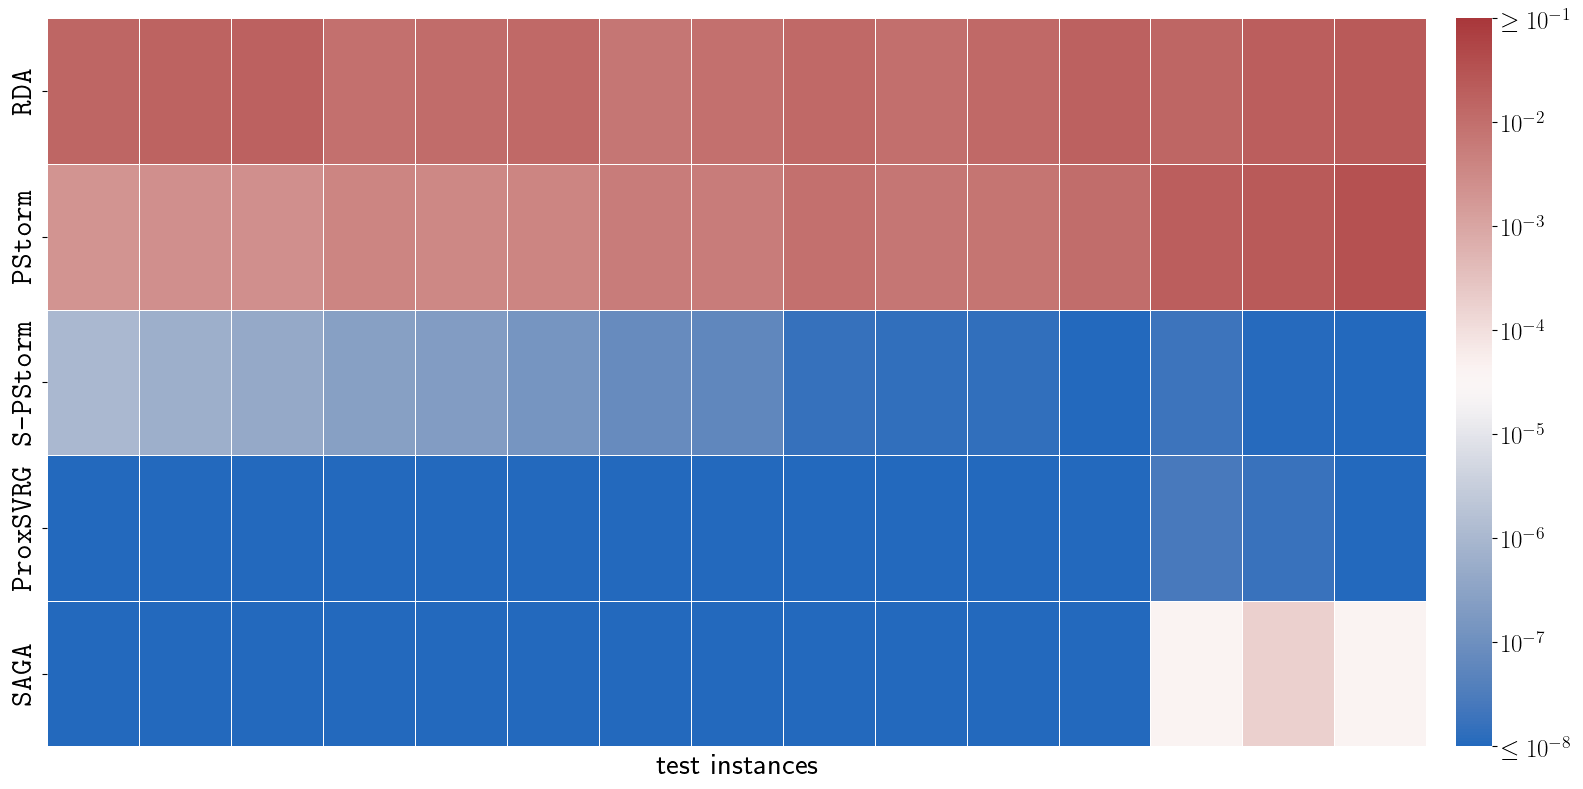

In [14]:
metric = 'best_F'
cols = ['ProxGD_F']
for solver in solvers:
    cols += [f'{solver}_{metric}']
df_Fval = df[cols].fillna(1e18)
df_Fval['problem_id'] = df['problem_id']
for solver in solvers:
    df_Fval[f'{solver}_{metric}_diff'] = np.abs(df_Fval[f'{solver}_{metric}'] - df_Fval['ProxGD_F']) /  df_Fval['ProxGD_F']
cols = []    
for solver in solvers:
    cols += [f'{solver}_{metric}_diff']
df_Fval_diff = df_Fval[cols]
heat_map_data = df_Fval_diff.to_numpy().T
heat_map_data_log = np.log10(heat_map_data+1e-18)

plt.figure(figsize=(16,8))
ax = sns.heatmap(heat_map_data_log, linewidths=.5, cmap= sns.color_palette("vlag", as_cmap=True), vmin=-8, vmax=-1, cbar_kws={"fraction": 0.05, 'pad':0.02})
ax.set_yticklabels(legend_label, fontsize=22)
ax.set_xlabel('test instances', fontsize=22)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# ax.set_title('F_{best} - F^*', fontsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-8, -7, -6,  -5, -4, -3, -2, -1])
cbar.set_ticklabels([r'$\leq 10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$\geq 10^{-1}$'])
cbar.ax.tick_params(labelsize=18) 
plt.tight_layout(w_pad=0)
plt.savefig('./figs/Fval_diff_ipg_ls_tree.pdf', dpi=100)

In [15]:
df_Fval_diff

,RDA_best_F_diff,PStorm_best_F_diff,SPStorm_best_F_diff,ProxSVRG_best_F_diff,ProxSAGA_best_F_diff
0,0.014670,0.002037,1.054695e-06,2.170872e-10,2.170868e-10
1,0.016939,0.002507,6.080594e-07,2.161922e-10,2.161922e-10
2,0.018203,0.002487,4.549578e-07,1.324355e-10,1.324355e-10
3,0.009552,0.003790,2.577181e-07,4.792752e-10,4.792748e-10
4,0.011399,0.003456,2.149751e-07,4.980043e-10,4.980043e-10
5,0.012816,0.003884,1.371230e-07,2.015780e-10,2.015780e-10
6,0.007274,0.005808,7.512985e-08,1.816048e-09,1.816048e-09
7,0.009224,0.005672,5.937349e-08,1.157700e-09,1.157700e-09
8,0.013244,0.009214,1.585363e-08,3.007325e-10,3.007323e-10
9,0.010262,0.007254,1.393005e-08,6.982795e-09,6.982794e-09


# Convergence Progress

In [16]:
def plot_convergence(actual_seed = 2023, depth=11, remove_ratio=0.1,
                     xval_end = 500,  support_end = 500,  grad_erro_end = 500,
                     exclude=None, result=False, max_epoch
                     =500):
   
    solvers = ["RDA", "PStorm", "SPStorm", "ProxSVRG", "ProxSAGA",]
    legend_label=[r'$\texttt{RDA}$', r'$\texttt{PStorm}$', r'$\texttt{S-PStorm}$', r'$\texttt{ProxSVRG}$', r'$\texttt{SAGA}$', ]
    problem_id, all_solver_stats = collect_one_run(actual_seed, depth, remove_ratio)
    xstar = all_solver_stats['ProxGD']['xsol']
    x_seq_distance = {}
    inner_seq = {}
    for solver in solvers:
        x_seq = all_solver_stats[solver]['x_seq']
        temp = [0] * len(x_seq)
        for i in range(len(x_seq)):
            temp[i] = np.linalg.norm((x_seq[i] - xstar).toarray())
        x_seq_distance[solver] = temp
        inner_seq[solver] = all_solver_stats[solver]['total_bak_seq'] + all_solver_stats[solver]['inner_its_seq'] 

    # fig, axs = plt.subplots(1, 4, figsize=(48,6))
    fig, axs = plt.subplots(1, 3, figsize=(36,6))
    for i, solver in enumerate(solvers):
        num_data_pass = all_solver_stats[solver]['num_data_pass']
        xdist_seq = x_seq_distance[solver][:-1]
        inner_workload = inner_seq[solver][:-1]
        nz_seq = all_solver_stats[solver]['nz_seq'][:-1]
        grad_error_seq = all_solver_stats[solver]['grad_error_seq'][1:]
        axs[0].plot(range(1, num_data_pass+1)[:min(num_data_pass,xval_end,len(xdist_seq))], 
                    xdist_seq[:min(num_data_pass,xval_end,len(xdist_seq))], label=legend_label[i])
        axs[1].plot(range(1, num_data_pass+1)[:min(num_data_pass,grad_erro_end,len(grad_error_seq))], 
                    grad_error_seq[:min(num_data_pass,grad_erro_end, len(grad_error_seq))], label=legend_label[i])
        axs[2].plot(range(1, num_data_pass+1)[:min(num_data_pass,support_end,len(nz_seq))], 
                    nz_seq[:min(num_data_pass,support_end,len(nz_seq))], label=legend_label[i])
        # axs[3].plot(range(1, num_data_pass+1)[:min(num_data_pass,xval_end,len(inner_workload))], 
        #             inner_workload[:min(num_data_pass,xval_end,len(inner_workload))], label=legend_label[i])
    # xref = np.arange(1,max_epoch+1) 
    # yref = np.sqrt(np.log(xref)/xref)
    # yref[0] = 1.0
    # axs[0].plot(range(1, num_data_pass+1)[:min(num_data_pass,xval_end)], yref[:min(num_data_pass,xval_end)], 'k-.', label=r"$\sqrt{\log k/k}$")      
    # axs[1].plot(range(1, num_data_pass+1)[:min(num_data_pass,xval_end)], 0.1 * yref[:min(num_data_pass,xval_end)], 'k-.', label=r"$\sqrt{\log k/k}$")    
    axs[2].axhline(all_solver_stats['ProxGD']['nz'], color='black', linewidth=2, alpha=0.5)    


    axs[0].set_xlabel('number of data pass', fontsize=20)
    axs[0].set_ylabel(r'$\|x_k-x^*\|$', fontsize=20)
    axs[0].set_yscale('log')
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 16})
    axs[0].tick_params(axis='both', which='major', labelsize=20)

    axs[1].set_xlabel('number of data pass', fontsize=20)
    axs[1].set_ylabel('error in the gradient estimate', fontsize=20)
    axs[1].set_yscale('log')
    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 16})
    axs[1].tick_params(axis='both', which='major', labelsize=20)

    axs[2].set_xlabel('number of data pass', fontsize=20)
    axs[2].set_ylabel('number of zero groups', fontsize=20)
    axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 16})
    axs[2].tick_params(axis='both', which='major', labelsize=20)
    
    # axs[3].set_xlabel('number of data pass', fontsize=20)
    # axs[3].set_ylabel('\#inner iters + \# backtracking', fontsize=20)
    # axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 16})
    # axs[3].tick_params(axis='both', which='major', labelsize=20)

    fig.tight_layout()   
    plt.savefig(f'./figs/convergence_{depth}_{remove_ratio}_ls_tree.pdf', dpi=100)
    if result:
        return x_seq_distance

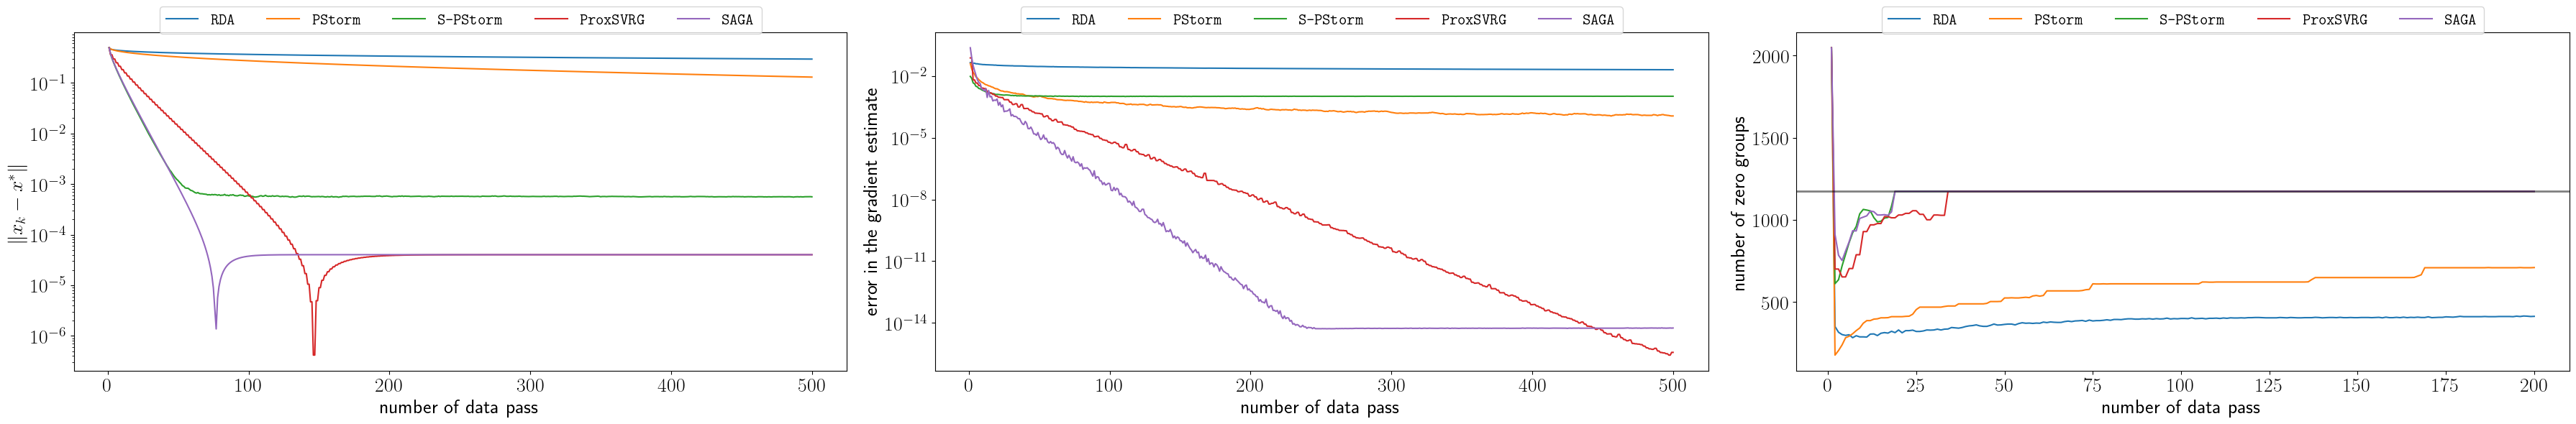

In [17]:
plot_convergence(actual_seed = 2023, depth=11, remove_ratio=0.1,
                  xval_end = 500,  support_end = 200,  grad_erro_end = 500)

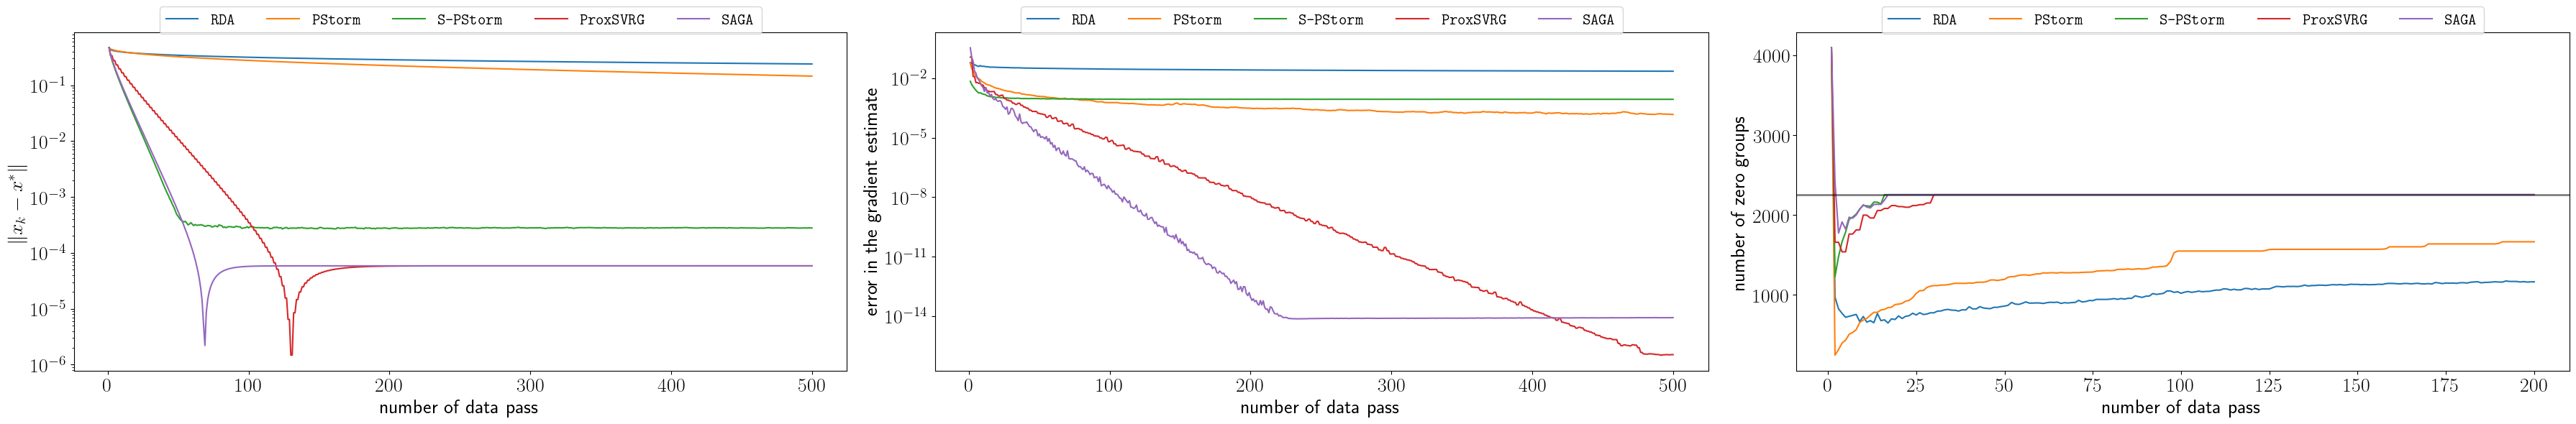

In [18]:
plot_convergence(actual_seed = 2023, depth=12, remove_ratio=0.1,
                  xval_end = 500,  support_end = 200,  grad_erro_end = 500)

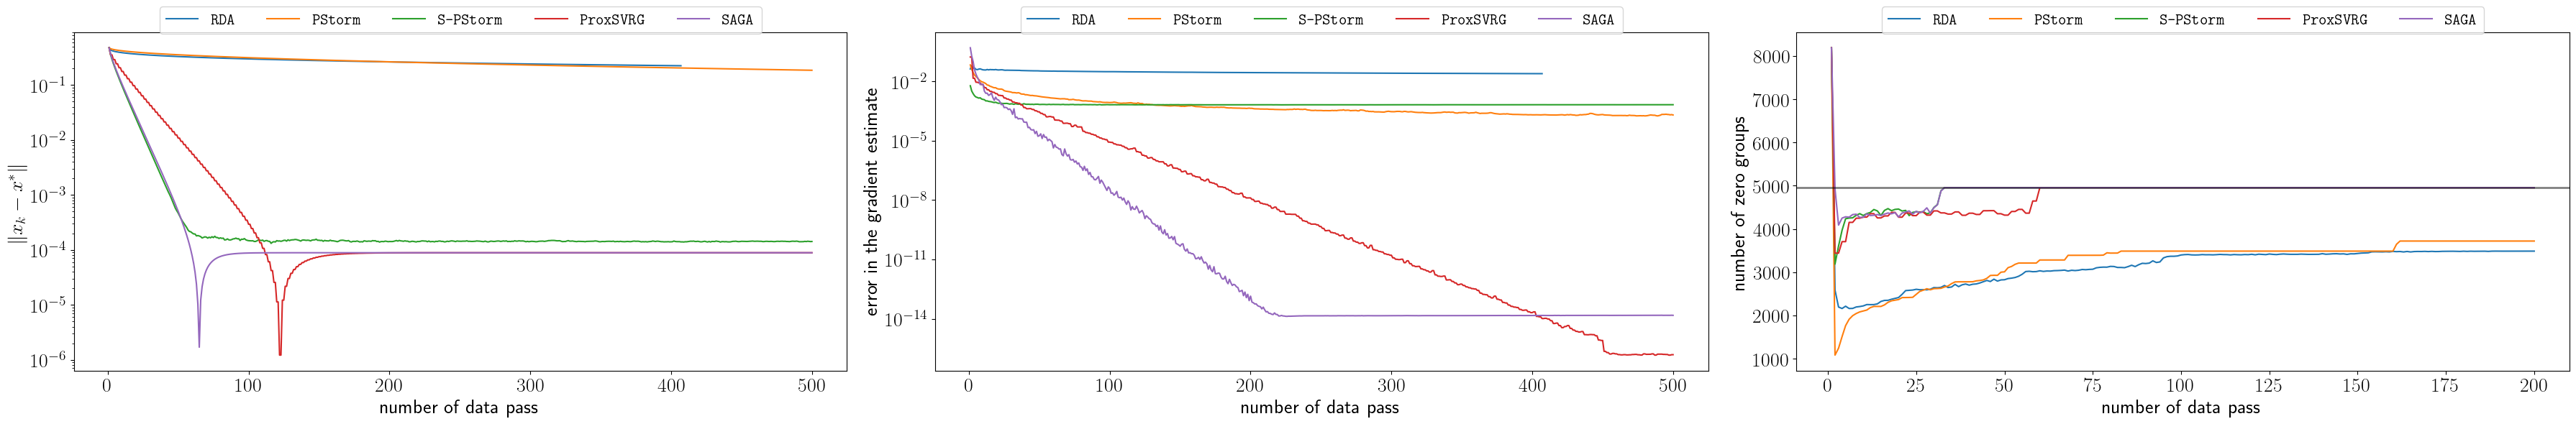

In [19]:
plot_convergence(actual_seed = 2023, depth=13, remove_ratio=0.1,
                  xval_end = 500,  support_end = 200,  grad_erro_end = 500)

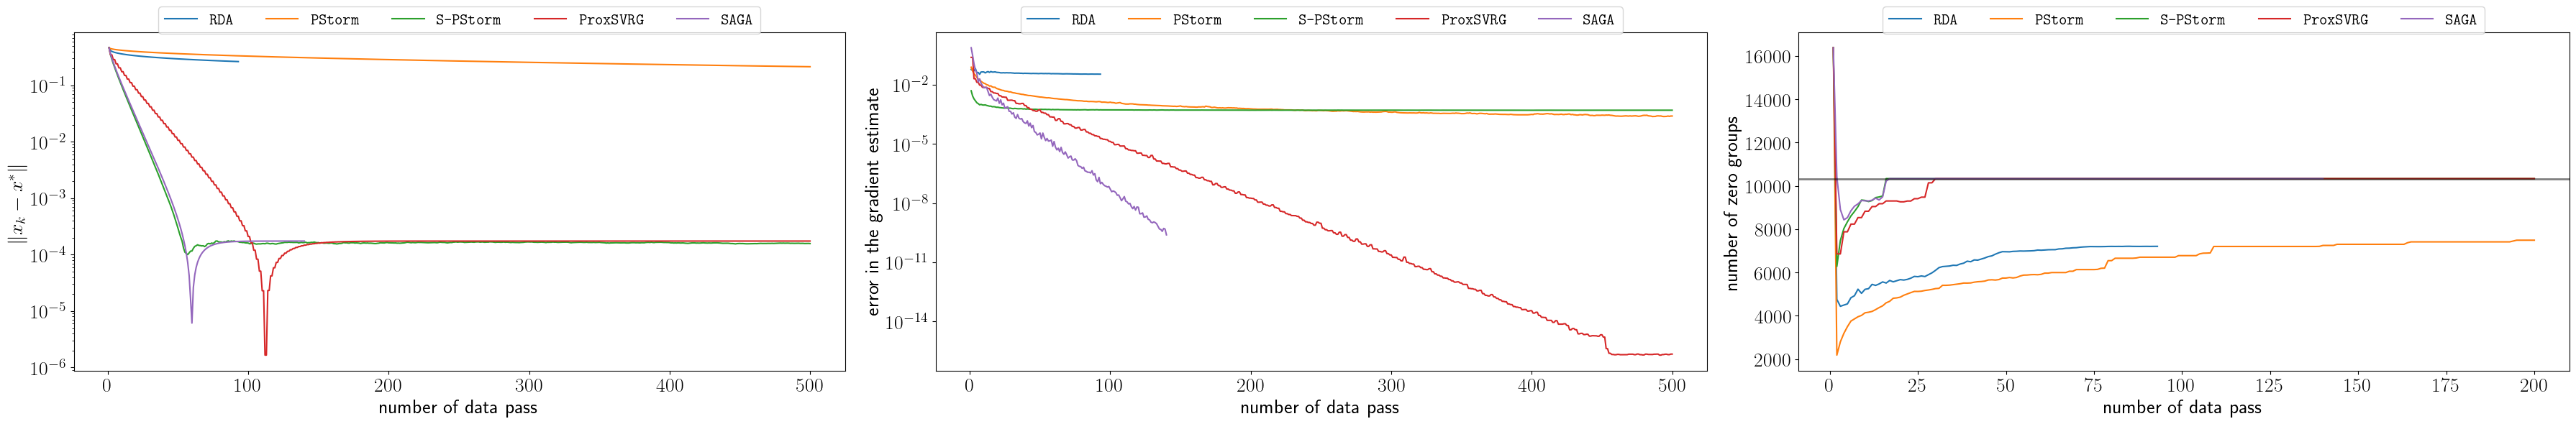

In [20]:
plot_convergence(actual_seed = 2023, depth=14, remove_ratio=0.1,
                  xval_end = 500,  support_end = 200,  grad_erro_end = 500)

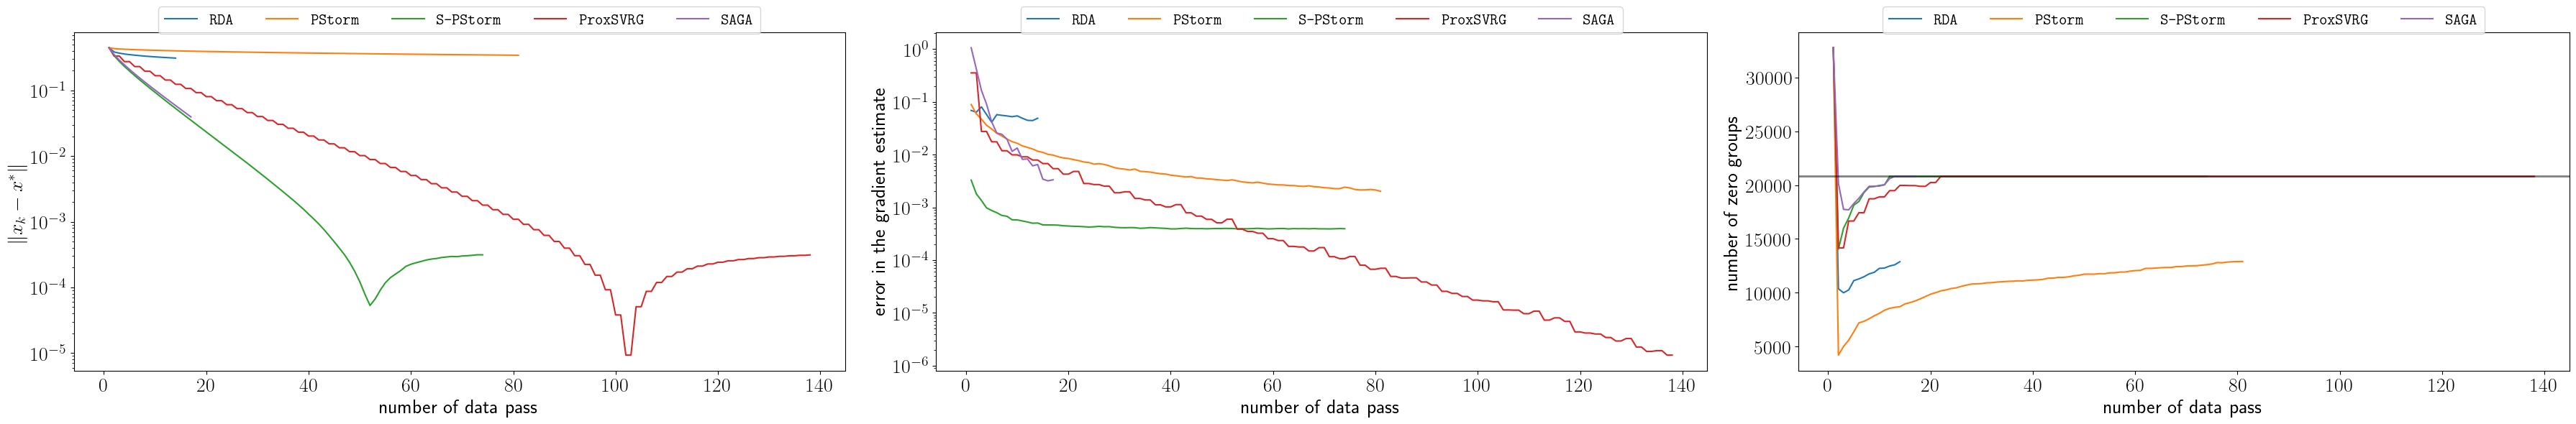

In [21]:
plot_convergence(actual_seed = 2023, depth=15, remove_ratio=0.1,
                  xval_end = 500,  support_end = 200,  grad_erro_end = 500)